In [120]:
from openai import OpenAI
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from twilio.rest import Client
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [121]:
url = "https://boardgamegeek.com/browse/boardgame/page/1?sort=rank&sortdir=asc"

In [122]:

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

url = "https://boardgamegeek.com/browse/boardgame/page/1?sort=rank&sortdir=asc"
driver = webdriver.Chrome()
driver.maximize_window()
driver.get(url)
WebDriverWait(driver, 3)
#response = requests.get(url, "lxml", headers=headers)
soup = BeautifulSoup(driver.page_source, "lxml")
#html = response.content 

#soup = BeautifulSoup(html)

# Scrap info from the site

### title of games

In [4]:
titles = [i.text for i in soup.select("a.primary")]
titles

['Brass: Birmingham',
 'Pandemic Legacy: Season 1',
 'Gloomhaven',
 'Ark Nova',
 'Twilight Imperium: Fourth Edition',
 'Dune: Imperium',
 'Terraforming Mars',
 'War of the Ring: Second Edition',
 'Star Wars: Rebellion',
 'Gloomhaven: Jaws of the Lion',
 'Spirit Island',
 'Gaia Project',
 'Twilight Struggle',
 'Through the Ages: A New Story of Civilization',
 'Great Western Trail',
 'The Castles of Burgundy',
 'Scythe',
 'Eclipse: Second Dawn for the Galaxy',
 '7 Wonders Duel',
 'Brass: Lancashire',
 'Nemesis',
 'Clank! Legacy: Acquisitions Incorporated',
 'A Feast for Odin',
 'Concordia',
 'Wingspan',
 'Arkham Horror: The Card Game',
 'Terra Mystica',
 'Lost Ruins of Arnak',
 'Great Western Trail: Second Edition',
 'Root',
 'Frosthaven',
 'Orléans',
 'Too Many Bones',
 'Mage Knight Board Game',
 'Everdell',
 'The Crew: Mission Deep Sea',
 'Barrage',
 'Viticulture Essential Edition',
 'Food Chain Magnate',
 'Marvel Champions: The Card Game',
 'Pax Pamir: Second Edition',
 'Heat: Pedal t

### year of publish

In [5]:
year = [i.text for i in soup.select("span.smallerfont.dull")]
years = [y.replace('(', '').replace(')', '') for y in year]


### Create ranking

In [6]:
rank = [i for i in range(1,101)]

### get 100 rows

In [10]:
rows = [i.text for i in soup.select("tr#row_")]

In [11]:

url = 'https://boardgamegeek.com/browse/boardgame/page/1?sort=rank&sortdir=asc'

# Send a GET request to the webpage
response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')

from bs4 import BeautifulSoup

board_urls = []
amazon_urls = []

# Assuming `rows` is a BeautifulSoup ResultSet or Tag object containing the rows
for row in rows:
    # Convert the row to BeautifulSoup Tag object if needed
    if not isinstance(row, BeautifulSoup):
        row = BeautifulSoup(row, 'html.parser')

    # Find all anchor tags within the row
    anchor_tags = row.find_all('a')
    
    # Loop through each anchor tag to find the href attribute
    for tag in anchor_tags:
        href = tag.get('href')
        
        # Check if the href attribute exists
        if href:
            # Depending on the content of the URL, append it to the respective list
            if 'board' in href:
                board_urls.append(href)
            elif 'amazon' in href:
                amazon_urls.append(href)

print("Board URLs:", board_urls)
print("Amazon URLs:", amazon_urls)

Board URLs: []
Amazon URLs: []


### all the ratings

In [12]:
rating = [i.text for i in soup.select("td.collection_bggrating")]

In [13]:
# clearing and extracting only the digits
ratings = [float(re.findall(r'\d+\.\d+|\d+', item)[0]) for item in rating]

In [14]:
# separating the ratings to different list 
Geek_rating = ratings[0::3]
Avg_rating = ratings[1::3]
Numb_voters = ratings[2::3]

### Get the Amazon links

In [15]:
# get all the links from the site
links = [i["href"] for i in soup.find_all("a", href=True)]


In [16]:
# extract only the boardgame links
actual_links = [i for i in links if i.startswith("/boardgame/")]
len(actual_links)

200

In [17]:
#remove duplicates to form the final list
b_links = []
for i in actual_links:
    if i not in b_links:
        b_links.append(i)
        
board_links = []   

unique_numbers = {}

for link in b_links:    
    middle_number = link.split('/')[2]

    if middle_number not in unique_numbers:
        unique_numbers[middle_number] = True
        board_links.append(link)
len(board_links)

100

In [18]:
pattern = r"/boardgame/\d+/\S+"

# Extract matching values from the list
matches_1 = [re.search(pattern, string).group() for string in Amazon_links if re.search(pattern, string)]
matches_1

NameError: name 'Amazon_links' is not defined

In [ ]:
matches_1 = matches_1[10:] + matches_1[:10]



# Extract the string after the middle number in each link and remove "-"
strings_after_middle_number = []
full_link = []
for link in matches_1:
    parts = link.split('/')
    middle_part = parts[2]  # The middle part contains the board game ID
    middle_number = int(middle_part)
    index_of_middle_number = link.index(middle_part)
    string_after_middle_number = link[index_of_middle_number + len(middle_part) + 1:].replace("-", " ")  # +1 for the '/' after the number
    strings_after_middle_number.append(string_after_middle_number)
    full_link.append(link)
# Match titles with the extracted strings
title_to_link_map = {}
for title, string_after_middle_number in zip(titles, strings_after_middle_number):
    title_to_link_map[title] = string_after_middle_number

# Print the matched titles and strings
#for title, link in title_to_link_map.items():
   #print(title, "->", link)


### Get Amazon Prices

In [20]:
price_strings = [i.text for i in soup.select("td.collection_shop")]


In [21]:
Amazon_prices = []
for row in price_strings:
    match = re.search(r'Amazon:\xa0\$([\d.]+)', row)
    if match:
        Amazon_prices.append(float(match.group(1)))
    else:
        Amazon_prices.append(np.nan)

### Add short description to each game

In [22]:
descr = [i.text for i in soup.select("p.smallefont.dull")]
Description = [d.replace('\n', '').replace('\t', '') for d in descr]

### Get the type of every game

In [23]:
#"Column6": Amazon_links

### create a DataFrame

In [24]:
data = {"Title": titles, "Rank": rank,"Release_Date": years, "Geek_rating": Geek_rating, "AVG_rating": Avg_rating,
        "Total_Votes": Numb_voters, "Amazon_Price($)": Amazon_prices, "Brief Description": Description}


df = pd.DataFrame(data)

In [25]:
df

,Title,Rank,Release_Date,Geek_rating,AVG_rating,Total_Votes,Amazon_Price($),Brief Description
0,Brass: Birmingham,1,2018,8.416,8.60,44958.0,NaN,"Build networks, grow industries, and navigate ..."
1,Pandemic Legacy: Season 1,2,2015,8.382,8.53,53173.0,NaN,Mutating diseases are spreading around the wor...
2,Gloomhaven,3,2017,8.357,8.59,61797.0,NaN,Vanquish monsters with strategic cardplay. Ful...
3,Ark Nova,4,2021,8.333,8.54,42260.0,NaN,"Plan and build a modern, scientifically manage..."
4,Twilight Imperium: Fourth Edition,5,2017,8.243,8.61,23444.0,NaN,"Build an intergalactic empire through trade, r..."
...,...,...,...,...,...,...,...,...
95,Decrypto,96,2018,7.540,7.77,22221.0,NaN,Decipher your opponents' code before they deci...
96,Architects of the West Kingdom,97,2018,7.540,7.73,28797.0,NaN,Will you be a virtuous or nefarious servant of...
97,Inis,98,2016,7.538,7.83,19968.0,NaN,Claim the crown through merit and wisdom in th...
98,Concordia Venus,99,2018,7.536,8.29,5710.0,NaN,Merchants build and trade throughout the Roman...


In [26]:
# https://boardgamegeek.com/boardgame/224517/brass-birmingham

### taking all titles

In [123]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Initialize the WebDriver
driver = webdriver.Chrome()

all_titles = []

for i in range(1, 11):
    url = f"https://boardgamegeek.com/browse/boardgame/page/{i}?sort=rank&sortdir=asc"
    driver.get(url)
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "a.primary")))
    
    # Agree to cookies
    agree_button_selector = "button#fc-button.fc-cta-consent.fc-primary-button"
    try:
        agree_button = driver.find_element(By.CSS_SELECTOR, agree_button_selector)
        agree_button.click()
    except:
        pass

    # Scroll to the bottom of the page
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    
    # Parse the page source
    soup = BeautifulSoup(driver.page_source, "lxml")
    container = soup.select("a.primary")
    
    for j in container:
        title = j.text.strip()
        all_titles.append(title)

driver.quit()
#all_titles


### taking all_years

In [163]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Initialize the WebDriver
driver = webdriver.Chrome()

all_years = []

for i in range(1, 11):
    url = f"https://boardgamegeek.com/browse/boardgame/page/{i}?sort=rank&sortdir=asc"
    driver.get(url)
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "span.smallerfont.dull")))
    
    # Agree to cookies
    agree_button_selector = "button#fc-button.fc-cta-consent.fc-primary-button"
    try:
        agree_button = driver.find_element(By.CSS_SELECTOR, agree_button_selector)
        agree_button.click()
    except:
        pass

    # Scroll to the bottom of the page
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    
    # Parse the page source
    soup = BeautifulSoup(driver.page_source, "lxml")
    container = soup.select("span.smallerfont.dull")
    
    for j in container:
        year = j.text.strip()
        all_years.append(year)

driver.quit()
#all_years


In [164]:
every_year = [y.replace('(', '').replace(')', '') for y in all_years]

### taking all ratings

In [126]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Initialize the WebDriver
driver = webdriver.Chrome()

all_ratings = []

for i in range(1, 11):
    url = f"https://boardgamegeek.com/browse/boardgame/page/{i}?sort=rank&sortdir=asc"
    driver.get(url)
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "td.collection_bggrating")))
    
    # Agree to cookies
    agree_button_selector = "button#fc-button.fc-cta-consent.fc-primary-button"
    try:
        agree_button = driver.find_element(By.CSS_SELECTOR, agree_button_selector)
        agree_button.click()
    except:
        pass

    # Scroll to the bottom of the page
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    
    # Parse the page source
    soup = BeautifulSoup(driver.page_source, "lxml")
    container = soup.select("td.collection_bggrating")
    
    for j in container:
        rate = j.text.strip()
        all_ratings.append(rate)

driver.quit()
#all_ratings


In [127]:
all_Geek_rating = all_ratings[0::3]
all_Avg_rating = all_ratings[1::3]
all_Numb_voters = all_ratings[2::3]

### get all Amazon prices

In [128]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Initialize the WebDriver
driver = webdriver.Chrome()

all_prices = []

for i in range(1, 11):
    url = f"https://boardgamegeek.com/browse/boardgame/page/{i}?sort=rank&sortdir=asc"
    driver.get(url)
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "td.collection_shop")))
    
    # Agree to cookies
    agree_button_selector = "button#fc-button.fc-cta-consent.fc-primary-button"
    try:
        agree_button = driver.find_element(By.CSS_SELECTOR, agree_button_selector)
        agree_button.click()
    except:
        pass

    # Scroll to the bottom of the page
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    
    # Parse the page source
    soup = BeautifulSoup(driver.page_source, "lxml")
    container = soup.select("td.collection_shop")
    
    for j in container:
        price = j.text.strip()
        all_prices.append(price)

driver.quit()
#all_prices


['List:\xa0$79.99\n\t\t\n\nAmazon:\xa0$70.45',
 'List:\xa0$89.99\n\t\t\n\nAmazon:\xa0$71.98',
 'Amazon:\xa0$309.95',
 'List:\xa0$74.95\n\t\t\n\nAmazon:\xa0$60.81',
 'Amazon:\xa0$131.99',
 'Amazon:\xa0$59.95',
 'List:\xa0$79.99\n\t\t\n\nAmazon:\xa0$58.76',
 'List:\xa0$89.99\n\t\t\n\nAmazon:\xa0$75.15',
 'Amazon:\xa0$89.81',
 'List:\xa0$49.99\n\t\t\n\nAmazon:\xa0$39.97',
 'List:\xa0$89.99\n\t\t\n\nAmazon:\xa0$64.99',
 'Amazon:\xa0$99.95',
 'List:\xa0$64.99\n\t\t\n\nAmazon:\xa0$54.74',
 'Amazon:\xa0$86.99',
 'List:\xa0$69.95\n\t\t\n\nAmazon:\xa0$49.99',
 'List:\xa0$49.99\n\t\t\n\nAmazon:\xa0$47.03',
 'List:\xa0$99.00\n\t\t\n\nAmazon:\xa0$66.90',
 'List:\xa0$184.49\n\t\t\n\nAmazon:\xa0$158.88',
 'List:\xa0$34.99\n\t\t\n\nAmazon:\xa0$21.99',
 'Amazon:\xa0$67.95',
 'List:\xa0$149.99\n\t\t\n\nAmazon:\xa0$119.99',
 'Amazon:\xa0$84.55',
 'List:\xa0$99.99\n\t\t\n\nAmazon:\xa0$91.40',
 'List:\xa0$64.99\n\t\t\n\nAmazon:\xa0$50.69',
 'List:\xa0$65.00\n\t\t\n\nAmazon:\xa0$43.99',
 'Amazon:\xa0$21.50

In [129]:
# clear values
Amazon_prices = []
for row in all_prices:
    match = re.search(r'Amazon:\xa0\$([\d.]+)', row)
    if match:
        Amazon_prices.append(float(match.group(1)))
    else:
        Amazon_prices.append(np.nan)

### get all the descriptions

In [130]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Initialize the WebDriver
driver = webdriver.Chrome()

all_description = []

for i in range(1, 11):
    url = f"https://boardgamegeek.com/browse/boardgame/page/{i}?sort=rank&sortdir=asc"
    driver.get(url)
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "p.smallefont.dull")))
    
    # Agree to cookies
    agree_button_selector = "button#fc-button.fc-cta-consent.fc-primary-button"
    try:
        agree_button = driver.find_element(By.CSS_SELECTOR, agree_button_selector)
        agree_button.click()
    except:
        pass

    # Scroll to the bottom of the page
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    
    # Parse the page source
    soup = BeautifulSoup(driver.page_source, "lxml")
    container = soup.select("p.smallefont.dull")
    
    for j in container:
        d = j.text.strip()
        all_description.append(d)

driver.quit()
#all_description


In [131]:
indices_to_replace = [548 ,688, 896]


for index in sorted(indices_to_replace, reverse=True):
    all_description.insert(index, np.nan)
    all_description[index+1] = all_description[index]

 

### get all rows 

In [180]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

driver = webdriver.Chrome()

all_rows = []

for i in range(1, 11):
    url = f"https://boardgamegeek.com/browse/boardgame/page/{i}?sort=rank&sortdir=asc"
    driver.get(url)
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "tr#row_")))
    
    # Agree to cookies
    agree_button_selector = "button#fc-button.fc-cta-consent.fc-primary-button"
    try:
        agree_button = driver.find_element(By.CSS_SELECTOR, agree_button_selector)
        agree_button.click()
    except:
        pass

    # Scroll to the bottom of the page
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    
    # Parse the page source
    soup = BeautifulSoup(driver.page_source, "lxml")
    container = soup.select("tr#row_")
    
    for j in container:
        d = j.text.strip()
        all_rows.append(d)

driver.quit()

### rank 1-1000

In [134]:
rank_1000 =[]
for i in range (1000):
    rank_1000.append(i+1)
    
rank_1000

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

### get boardgame links

In [188]:
board_links = []

for i in range(1, 11):
    url = f"https://boardgamegeek.com/browse/boardgame/page/{i}?sort=rank&sortdir=asc"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    board_links.extend([link.get('href') for link in soup.find_all('a', href=True) if link['href'].startswith("/boardgame/")])


In [349]:
b_links = []
for i in board_links:
    if i not in b_links:
        b_links.append(i)
        
boardgame_links = []   

unique_numbers = {}

for link in b_links:    
    middle_number = link.split('/')[2]

    if middle_number not in unique_numbers:
        unique_numbers[middle_number] = True
        boardgame_links.append(link)
len(boardgame_links)

1000

In [350]:
boardgame_links

['/boardgame/224517/brass-birmingham',
 '/boardgame/161936/pandemic-legacy-season-1',
 '/boardgame/174430/gloomhaven',
 '/boardgame/342942/ark-nova',
 '/boardgame/233078/twilight-imperium-fourth-edition',
 '/boardgame/316554/dune-imperium',
 '/boardgame/167791/terraforming-mars',
 '/boardgame/115746/war-ring-second-edition',
 '/boardgame/187645/star-wars-rebellion',
 '/boardgame/291457/gloomhaven-jaws-of-the-lion',
 '/boardgame/162886/spirit-island',
 '/boardgame/220308/gaia-project',
 '/boardgame/12333/twilight-struggle',
 '/boardgame/182028/through-ages-new-story-civilization',
 '/boardgame/193738/great-western-trail',
 '/boardgame/84876/castles-burgundy',
 '/boardgame/169786/scythe',
 '/boardgame/246900/eclipse-second-dawn-galaxy',
 '/boardgame/173346/7-wonders-duel',
 '/boardgame/28720/brass-lancashire',
 '/boardgame/167355/nemesis',
 '/boardgame/266507/clank-legacy-acquisitions-incorporated',
 '/boardgame/177736/a-feast-for-odin',
 '/boardgame/124361/concordia',
 '/boardgame/26619

### taking all Amazon links

In [132]:
url = "https://boardgamegeek.com/browse/boardgame/page/1?sort=rank&sortdir=asc"


headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

url = "https://boardgamegeek.com/browse/boardgame/page/1?sort=rank&sortdir=asc"
driver = webdriver.Chrome()
driver.maximize_window()
driver.get(url)
WebDriverWait(driver, 3)
#response = requests.get(url, "lxml", headers=headers)
soup = BeautifulSoup(driver.page_source, "lxml")
#html = response.content 

container = soup.select("td.collection_shop")

def item_extract(elem, selector):
    parse = elem.find_all(selector, href=True)
    if parse == []:
        return np.nan
    else:
        return parse[0]

    
link_selector = "a" 
link_lst = []

for j in range(1, 11):
    url = f"https://boardgamegeek.com/browse/boardgame/page/{j}?sort=rank&sortdir=asc"
    #response = requests.get(url)
    driver.get(url)
    WebDriverWait(driver, 5)
    soup = BeautifulSoup(driver.page_source, "lxml")
                            
    #soup = BeautifulSoup(response.content, 'html.parser')
    container = soup.select("td.collection_shop")
    
    for i in container:
        
        link = item_extract(i,link_selector )
        link_lst.append(link)

    count = 0   
    ama_lst=[]
    for i in link_lst:
        if link_lst[count]:
            ama_lst.append(i)
        else:
            ama_lst.append(np.nan)
        count+=1


<td class="collection_shop">
<div class="aad" id="aad_thing_224517_textwithprices__"><div>
<div>
			List: $79.99
		</div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/1988884047?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$70.45</span></a>
</div>
</div>
</div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_161936_textwithprices__"><div>
<div>
			List: $89.99
		</div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B00TQ0DXR2?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$71.98</span></a>
</div>
</div>
</div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_174430_textwithprices__"><div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B01LZXVN4P?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$309.95</span></a>
</div>
</div>
</

<td class="collection_shop">
<div class="aad" id="aad_thing_122515_textwithprices__"><div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B009AP8XS2?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$64.99</span></a>
</div>
</div>
</div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_170042_textwithprices__"><div>
<div>
			List: $60.00
		</div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B0721VGFKF?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$46.76</span></a>
</div>
</div>
</div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_42_textwithprices__"></div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_310873_textwithprices__"><div>
<div>
			List: $56.49
		</div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B09P3MYZ65?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1

<td class="collection_shop">
<div class="aad" id="aad_thing_25021_textwithprices__"><div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B0073KK8SY?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$74.69</span></a>
</div>
</div>
</div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_271896_textwithprices__"><div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B07NRHKD64?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$59.99</span></a>
</div>
</div>
</div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_128882_textwithprices__"><div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B009SAAV0C?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$23.99</span></a>
</div>
</div>
</div>
</td>
<td class="collection_shop">
<div class="aad" id="aad

<td class="collection_shop">
<div class="aad" id="aad_thing_92828_textwithprices__"></div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_206718_textwithprices__"></div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_108745_textwithprices__"><div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B008A2BA90?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$69.15</span></a>
</div>
</div>
</div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_244271_textwithprices__"><div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/1988884527?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$225.00</span></a>
</div>
</div>
</div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_291572_textwithprices__"><div>
<div>
			List: $120.00
		</div>
<div>
<a class="ulprice" href="https://www.amazon

<td class="collection_shop">
<div class="aad" id="aad_thing_101721_textwithprices__"><div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B007EZM85O?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$99.99</span></a>
</div>
</div>
</div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_40354_textwithprices__"></div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_350316_textwithprices__"><div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B0BB8HD4PJ?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$47.01</span></a>
</div>
</div>
</div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_25554_textwithprices__"><div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B000Q84NVS?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$

<td class="collection_shop">
<div class="aad" id="aad_thing_194607_textwithprices__"><div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B01DMZR1QU?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$77.95</span></a>
</div>
</div>
</div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_158899_textwithprices__"><div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B00OZTUQWE?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$43.19</span></a>
</div>
</div>
</div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_355093_textwithprices__"><div>
<div>
			List: $64.14
		</div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B0BMM7RT8X?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$49.93</span></a>
</div>
</div>
</div>
</td>
<td class="collection

<td class="collection_shop">
<div class="aad" id="aad_thing_503_textwithprices__"></div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_183251_textwithprices__"><div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B015FW1092?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$39.99</span></a>
</div>
</div>
</div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_102652_textwithprices__"><div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B0095ZFA5Q?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$60.94</span></a>
</div>
</div>
</div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_340466_textwithprices__"><div>
<div>
			List: $79.95
		</div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B096KW4QWX?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Am

<td class="collection_shop">
<div class="aad" id="aad_thing_119432_textwithprices__"></div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_153016_textwithprices__"><div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B0083J768O?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$39.99</span></a>
</div>
</div>
</div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_135779_textwithprices__"><div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B00KKBJZ5K?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$24.00</span></a>
</div>
</div>
</div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_1513_textwithprices__"></div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_198953_textwithprices__"></div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_21763_textwithpr

<td class="collection_shop">
<div class="aad" id="aad_thing_15364_textwithprices__"><div>
<div>
			List: $44.99
		</div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B0009XS9LA?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$39.95</span></a>
</div>
</div>
</div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_168435_textwithprices__"></div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_9823_textwithprices__"><div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B000V3UH1S?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$53.99</span></a>
</div>
</div>
</div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_238799_textwithprices__"><div>
<div>
			List: $44.89
		</div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B0B1LS464N?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=

<td class="collection_shop">
<div class="aad" id="aad_thing_163602_textwithprices__"><div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/1616619686?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$162.50</span></a>
</div>
</div>
</div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_122298_textwithprices__"><div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B00CS41TQ0?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$26.95</span></a>
</div>
</div>
</div>
</td>
<td class="collection_shop">
<div class="aad" id="aad_thing_179275_textwithprices__"><div>
<div>
			List: $25.00
		</div>
<div>
<a class="ulprice" href="https://www.amazon.com/dp/B01NBIJZAN?tag=browse-boardgamegeek-20&amp;linkCode=ogi&amp;th=1&amp;psc=1" target="_blank">Amazon: <span class="positive">$20.16</span></a>
</div>
</div>
</div>
</td>
<td class="collectio

In [133]:
# extract the urls
Amazon_urls = []
for item in ama_lst:
    soup = BeautifulSoup(str(item), 'html.parser')
    url_tag = soup.find('a', class_='ulprice')
    if url_tag:
        Amazon_urls.append(url_tag['href'])
    else:
        Amazon_urls.append(np.nan)



### Taking gender

In [ ]:
# saved the list so i wont run it again unless values change on the site
            from selenium import webdriver

            def scrape_game_type(boardgame_links):
                driver = webdriver.Chrome()
                driver.maximize_window()
                game_type_list = []

                try:
                    for link in boardgame_links:
                        url = f"https://boardgamegeek.com{link}"
                        driver.get(url)

                        # Find all span elements with class 'rank-title' and 'ng-binding'
                        game_type_elements = driver.find_elements("css selector", 'span.rank-title.ng-binding')

                        # Extract the text content of the second span element if it exists
                        game_type = game_type_elements[1].text.strip() if len(game_type_elements) > 1 else "N/A"

                        game_type_list.append({"Link": link, "Game Type": game_type})
                finally:
                    driver.quit()

                return game_type_list


            game_type_data = scrape_game_type(boardgame_links)
            game_genre = [entry["Game Type"] for entry in game_type_data]

In [194]:
game_genr = ['STRATEGY', 'THEMATIC', 'THEMATIC', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'WAR', 'THEMATIC', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'WAR', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'CUSTOMIZABLE', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'WAR', 'THEMATIC', 'STRATEGY', 'THEMATIC', 'THEMATIC', 'FAMILY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'CUSTOMIZABLE', 'STRATEGY', 'FAMILY', 'STRATEGY', 'STRATEGY', 'ABSTRACT', 'STRATEGY', 'FAMILY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'THEMATIC', 'THEMATIC', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'FAMILY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'FAMILY', 'THEMATIC', 'CUSTOMIZABLE', 'THEMATIC', 'THEMATIC', 'ABSTRACT', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'THEMATIC', 'PARTY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'THEMATIC', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'FAMILY', 'STRATEGY', 'ABSTRACT', 'STRATEGY', 'STRATEGY', 'FAMILY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'PARTY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'FAMILY', 'STRATEGY', 'THEMATIC', 'PARTY', 'FAMILY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'FAMILY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'CUSTOMIZABLE', 'CUSTOMIZABLE', 'WAR', 'THEMATIC', 'WAR', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'FAMILY', 'STRATEGY', 'ABSTRACT', 'THEMATIC', 'FAMILY', 'STRATEGY', 'STRATEGY', 'FAMILY', 'STRATEGY', 'THEMATIC', 'THEMATIC', 'WAR', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'THEMATIC', 'THEMATIC', 'WAR', 'ABSTRACT', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'THEMATIC', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'ABSTRACT', 'WAR', 'THEMATIC', 'PARTY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'FAMILY', 'STRATEGY', 'FAMILY', 'STRATEGY', 'ABSTRACT', 'THEMATIC', 'STRATEGY', 'THEMATIC', 'WAR', 'STRATEGY', 'THEMATIC', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'FAMILY', 'STRATEGY', 'FAMILY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'ABSTRACT', 'WAR', 'STRATEGY', 'WAR', 'ABSTRACT', 'STRATEGY', 'FAMILY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'PARTY', 'STRATEGY', 'PARTY', 'THEMATIC', 'PARTY', 'STRATEGY', 'PARTY', 'FAMILY', 'FAMILY', 'FAMILY', 'THEMATIC', 'FAMILY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'FAMILY', 'STRATEGY', 'PARTY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'ABSTRACT', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'THEMATIC', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'FAMILY', 'STRATEGY', 'FAMILY', 'THEMATIC', 'STRATEGY', 'PARTY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'FAMILY', 'STRATEGY', 'ABSTRACT', 'STRATEGY', 'PARTY', 'STRATEGY', 'STRATEGY', 'FAMILY', 'THEMATIC', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'FAMILY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'PARTY', 'ABSTRACT', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'FAMILY', 'THEMATIC', 'THEMATIC', 'THEMATIC', 'STRATEGY', 'THEMATIC', 'PARTY', 'FAMILY', 'CUSTOMIZABLE', 'FAMILY', 'STRATEGY', 'FAMILY', 'STRATEGY', 'FAMILY', 'STRATEGY', 'STRATEGY', 'FAMILY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'FAMILY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'FAMILY', 'THEMATIC', 'THEMATIC', 'PARTY', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'FAMILY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'FAMILY', 'STRATEGY', 'STRATEGY', 'WAR', 'PARTY', 'FAMILY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'ABSTRACT', 'FAMILY', 'CUSTOMIZABLE', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'WAR', 'PARTY', 'STRATEGY', 'WAR', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'CUSTOMIZABLE', 'WAR', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'CUSTOMIZABLE', 'FAMILY', 'STRATEGY', 'FAMILY', 'STRATEGY', 'STRATEGY', 'WAR', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'FAMILY', 'FAMILY', 'STRATEGY', 'FAMILY', 'FAMILY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'WAR', 'STRATEGY', 'FAMILY', 'FAMILY', 'ABSTRACT', 'STRATEGY', 'WAR', 'PARTY', 'STRATEGY', 'STRATEGY', 'PARTY', 'STRATEGY', 'FAMILY', 'STRATEGY', 'THEMATIC', 'THEMATIC', 'FAMILY', 'ABSTRACT', 'THEMATIC', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'PARTY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'THEMATIC', 'THEMATIC', 'WAR', 'THEMATIC', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'ABSTRACT', 'STRATEGY', 'ABSTRACT', 'STRATEGY', 'WAR', 'STRATEGY', 'PARTY', 'THEMATIC', 'CUSTOMIZABLE', 'THEMATIC', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'WAR', 'WAR', 'STRATEGY', 'FAMILY', 'FAMILY', 'FAMILY', 'STRATEGY', 'FAMILY', 'STRATEGY', 'STRATEGY', 'WAR', 'FAMILY', 'CUSTOMIZABLE', "CHILDREN'S", 'FAMILY', 'THEMATIC', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'FAMILY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'FAMILY', 'STRATEGY', 'WAR', 'STRATEGY', 'FAMILY', 'PARTY', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'WAR', 'THEMATIC', 'STRATEGY', 'PARTY', 'STRATEGY', 'STRATEGY', 'PARTY', 'FAMILY', 'FAMILY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'FAMILY', 'THEMATIC', 'THEMATIC', 'FAMILY', 'THEMATIC', 'THEMATIC', 'THEMATIC', 'FAMILY', 'THEMATIC', 'THEMATIC', 'FAMILY', 'STRATEGY', 'STRATEGY', 'WAR', 'STRATEGY', 'FAMILY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'WAR', 'FAMILY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'WAR', 'ABSTRACT', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'PARTY', 'FAMILY', 'STRATEGY', 'ABSTRACT', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'FAMILY', 'STRATEGY', 'THEMATIC', 'FAMILY', 'ABSTRACT', 'PARTY', 'STRATEGY', 'THEMATIC', 'THEMATIC', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'PARTY', 'STRATEGY', 'STRATEGY', 'PARTY', 'STRATEGY', 'STRATEGY', 'FAMILY', 'ABSTRACT', 'FAMILY', 'THEMATIC', 'THEMATIC', 'FAMILY', 'THEMATIC', 'THEMATIC', 'WAR', 'STRATEGY', 'THEMATIC', 'THEMATIC', 'STRATEGY', 'ABSTRACT', 'FAMILY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'FAMILY', 'STRATEGY', 'STRATEGY', 'WAR', 'FAMILY', 'FAMILY', 'STRATEGY', 'WAR', 'THEMATIC', 'FAMILY', 'STRATEGY', 'THEMATIC', 'FAMILY', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'PARTY', 'STRATEGY', 'THEMATIC', 'PARTY', 'FAMILY', 'STRATEGY', 'FAMILY', 'STRATEGY', 'FAMILY', 'WAR', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'WAR', 'STRATEGY', 'THEMATIC', 'WAR', 'CUSTOMIZABLE', 'THEMATIC', 'FAMILY', 'THEMATIC', 'STRATEGY', 'WAR', 'STRATEGY', 'THEMATIC', 'THEMATIC', 'THEMATIC', 'THEMATIC', 'ABSTRACT', 'FAMILY', 'THEMATIC', 'THEMATIC', 'STRATEGY', 'FAMILY', 'STRATEGY', 'THEMATIC', 'ABSTRACT', 'CUSTOMIZABLE', 'WAR', 'THEMATIC', 'THEMATIC', 'FAMILY', 'ABSTRACT', 'STRATEGY', 'PARTY', 'STRATEGY', 'CUSTOMIZABLE', 'STRATEGY', 'FAMILY', 'FAMILY', 'STRATEGY', 'FAMILY', 'FAMILY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'PARTY', 'THEMATIC', 'STRATEGY', 'PARTY', 'PARTY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'FAMILY', 'FAMILY', 'CUSTOMIZABLE', 'THEMATIC', 'ABSTRACT', 'STRATEGY', 'STRATEGY', 'CUSTOMIZABLE', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'FAMILY', 'THEMATIC', 'STRATEGY', 'WAR', 'FAMILY', 'FAMILY', 'STRATEGY', 'ABSTRACT', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'PARTY', 'THEMATIC', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'WAR', 'FAMILY', 'FAMILY', 'THEMATIC', 'THEMATIC', 'ABSTRACT', 'THEMATIC', 'FAMILY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'THEMATIC', 'STRATEGY', 'ABSTRACT', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'CUSTOMIZABLE', 'FAMILY', 'STRATEGY', 'ABSTRACT', 'STRATEGY', 'THEMATIC', 'THEMATIC', 'FAMILY', 'FAMILY', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'FAMILY', 'STRATEGY', 'PARTY', 'WAR', 'STRATEGY', 'STRATEGY', 'FAMILY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'PARTY', 'WAR', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'FAMILY', 'FAMILY', 'FAMILY', 'STRATEGY', 'THEMATIC', 'FAMILY', 'STRATEGY', 'FAMILY', 'WAR', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'FAMILY', 'ABSTRACT', 'STRATEGY', 'STRATEGY', 'FAMILY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'FAMILY', 'THEMATIC', 'THEMATIC', 'STRATEGY', 'PARTY', 'ABSTRACT', 'FAMILY', 'FAMILY', 'ABSTRACT', 'STRATEGY', 'CUSTOMIZABLE', 'STRATEGY', 'FAMILY', 'FAMILY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'WAR', 'WAR', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'FAMILY', 'ABSTRACT', 'PARTY', 'STRATEGY', 'FAMILY', 'WAR', 'STRATEGY', 'THEMATIC', 'FAMILY', 'ABSTRACT', 'WAR', 'THEMATIC', 'PARTY', 'FAMILY', 'STRATEGY', 'STRATEGY', 'WAR', 'STRATEGY', 'THEMATIC', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'PARTY', 'FAMILY', 'CUSTOMIZABLE', 'STRATEGY', 'STRATEGY', 'ABSTRACT', 'STRATEGY', 'THEMATIC', 'FAMILY', 'FAMILY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'FAMILY', 'WAR', 'WAR', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'WAR', 'FAMILY', 'FAMILY', 'THEMATIC', 'STRATEGY', 'WAR', 'THEMATIC', 'STRATEGY', 'THEMATIC', 'FAMILY', 'STRATEGY', 'THEMATIC', 'FAMILY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'WAR', 'FAMILY', 'ABSTRACT', 'CUSTOMIZABLE', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'THEMATIC', 'WAR', 'THEMATIC', 'WAR', 'WAR', "CHILDREN'S", 'FAMILY', 'STRATEGY', 'PARTY', 'FAMILY', 'FAMILY', 'STRATEGY', 'WAR', 'STRATEGY', 'ABSTRACT', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'PARTY', 'THEMATIC', 'STRATEGY', 'ABSTRACT', 'STRATEGY', 'WAR', 'STRATEGY', 'THEMATIC', 'WAR', 'PARTY', 'FAMILY', 'PARTY', 'STRATEGY', 'PARTY', 'STRATEGY', 'PARTY', 'STRATEGY', 'THEMATIC', 'CUSTOMIZABLE', 'STRATEGY', 'THEMATIC', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'CUSTOMIZABLE', 'THEMATIC', 'STRATEGY', 'STRATEGY', 'STRATEGY', 'PARTY', 'STRATEGY', 'STRATEGY', 'THEMATIC', 'STRATEGY', 'FAMILY', 'FAMILY', 'STRATEGY', 'PARTY', 'ABSTRACT', 'THEMATIC', 'FAMILY', 'THEMATIC', 'THEMATIC', 'FAMILY', 'STRATEGY', 'STRATEGY', 'PARTY', 'STRATEGY', 'FAMILY', 'ABSTRACT', 'STRATEGY', 'STRATEGY', 'ABSTRACT', 'ABSTRACT', 'FAMILY', 'STRATEGY', 'THEMATIC', 'THEMATIC', 'STRATEGY', 'THEMATIC', 'THEMATIC', 'STRATEGY', 'THEMATIC', 'WAR', 'STRATEGY']

In [196]:
game_genre = []
for i in game_genr:
    game_genre.append(i.lower())


['strategy',
 'thematic',
 'thematic',
 'strategy',
 'thematic',
 'strategy',
 'strategy',
 'war',
 'thematic',
 'thematic',
 'strategy',
 'strategy',
 'war',
 'strategy',
 'strategy',
 'strategy',
 'strategy',
 'strategy',
 'strategy',
 'strategy',
 'thematic',
 'thematic',
 'strategy',
 'strategy',
 'strategy',
 'customizable',
 'strategy',
 'strategy',
 'strategy',
 'war',
 'thematic',
 'strategy',
 'thematic',
 'thematic',
 'family',
 'strategy',
 'strategy',
 'strategy',
 'strategy',
 'customizable',
 'strategy',
 'family',
 'strategy',
 'strategy',
 'abstract',
 'strategy',
 'family',
 'strategy',
 'strategy',
 'strategy',
 'strategy',
 'strategy',
 'thematic',
 'thematic',
 'thematic',
 'strategy',
 'thematic',
 'strategy',
 'thematic',
 'strategy',
 'strategy',
 'thematic',
 'strategy',
 'family',
 'strategy',
 'strategy',
 'strategy',
 'strategy',
 'thematic',
 'family',
 'thematic',
 'customizable',
 'thematic',
 'thematic',
 'abstract',
 'strategy',
 'strategy',
 'strategy',

## Make a df 

In [248]:
data = {"Title": all_titles, "Genre":game_genre, "Rank": rank_1000,"Release_Date": every_year, 
        "Geek_rating": all_Geek_rating, "AVG_rating": all_Avg_rating, "Total_Votes": all_Numb_voters, "Amazon_Price($)": Amazon_prices, 
        "Amazon_Link": Amazon_urls, "Brief Description": all_description}


df = pd.DataFrame(data)

In [249]:
df

,Title,Genre,Rank,Release_Date,Geek_rating,AVG_rating,Total_Votes,Amazon_Price($),Amazon_Link,Brief Description
0,Brass: Birmingham,strategy,1,2018,8.416,8.60,44976,70.45,https://www.amazon.com/dp/1988884047?tag=brows...,"Build networks, grow industries, and navigate ..."
1,Pandemic Legacy: Season 1,thematic,2,2015,8.382,8.53,53182,71.98,https://www.amazon.com/dp/B00TQ0DXR2?tag=brows...,Mutating diseases are spreading around the wor...
2,Gloomhaven,thematic,3,2017,8.357,8.59,61801,309.95,https://www.amazon.com/dp/B01LZXVN4P?tag=brows...,Vanquish monsters with strategic cardplay. Ful...
3,Ark Nova,strategy,4,2021,8.333,8.54,42289,60.81,https://www.amazon.com/dp/B09L6FCP9S?tag=brows...,"Plan and build a modern, scientifically manage..."
4,Twilight Imperium: Fourth Edition,thematic,5,2017,8.243,8.61,23453,131.99,https://www.amazon.com/dp/B074YPSTRP?tag=brows...,"Build an intergalactic empire through trade, r..."
...,...,...,...,...,...,...,...,...,...,...
995,Thunder Alley,thematic,996,2014,6.615,7.30,3576,48.85,https://www.amazon.com/dp/B00L3CTHLC?tag=brows...,Race your team of cars most efficiently to win...
996,Tidal Blades: Heroes of the Reef,strategy,997,2020,6.614,7.51,2899,NaN,NaN,"Join a tournament to become a Tidal Blade, gua..."
997,DinoGenics,thematic,998,2019,6.613,7.62,2395,NaN,NaN,Build and manage your own dinosaur island resort.
998,Virgin Queen,war,999,2012,6.613,8.01,1742,125.00,https://www.amazon.com/dp/B007PNT5B0?tag=brows...,Multiplayer European conflict during the Count...


In [ ]:
df["Title"]

In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              1000 non-null   object 
 1   Genre              1000 non-null   object 
 2   Rank               1000 non-null   int64  
 3   Release_Date       1000 non-null   object 
 4   Geek_rating        1000 non-null   object 
 5   AVG_rating         1000 non-null   object 
 6   Total_Votes        1000 non-null   object 
 7   Amazon_Price($)    700 non-null    float64
 8   Amazon_Link        700 non-null    object 
 9   Brief Description  994 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 78.3+ KB


In [250]:
df.loc[df['Title'] == 'Brass: Birmingham', 'Brief Description'].values[0]

'Build networks, grow industries, and navigate the world of the Industrial Revolution.'

In [200]:
df["Genre"].unique()

array(['strategy', 'thematic', 'war', 'customizable', 'family',
       'abstract', 'party', "children's"], dtype=object)

In [169]:
#Duplicate Boargame
duplicated_titles = df[df.duplicated(subset=['Title'], keep=False)]
duplicated_titles

,Title,Rank,Release_Date,Geek_rating,AVG_rating,Total_Votes,Amazon_Price($),Amazon_Link,Brief Description
189,Dune,190,2019,7.348,7.95,8553,50.00,https://www.amazon.com/dp/1947494503?tag=brows...,Wildly different factions vie for control of A...
336,Love Letter,337,2012,7.128,7.23,67304,19.78,https://www.amazon.com/dp/B00AGJ4HC2?tag=brows...,Can you get a letter to the princess or remove...
354,Love Letter,355,2019,7.110,7.52,9780,12.64,https://www.amazon.com/dp/B07PHHBWM9?tag=brows...,Help sneakily maneuver your love letter to the...
469,Dune,470,1979,6.991,7.59,5870,NaN,NaN,"Use unique strengths, treachery, and cunning t..."
489,Lord of the Rings: The Confrontation,490,2005,6.974,7.49,6383,NaN,NaN,Get Frodo to Mordor Stratego-style before shad...
505,Citadels,506,2016,6.956,7.25,13987,69.99,https://www.amazon.com/dp/B01MDLM6I2?tag=brows...,Thief? King? Warlord? Draft the best temporary...
519,Citadels,520,2000,6.945,7.06,54472,29.99,https://www.amazon.com/dp/B09CDSJMP5?tag=brows...,"Bishop, warlord, thief, king: change roles, bu..."
696,Lord of the Rings: The Confrontation,697,2002,6.796,7.21,6980,NaN,NaN,A game of hidden identities: help Frodo destro...


In [252]:
# Convert 'Geek_rating' column to numeric (float)
df['Geek_rating'] = pd.to_numeric(df['Geek_rating'])

In [146]:
# Group the data by 'Release_Date' and calculate the average 'Geek_rating'
average_geek_rating = df.groupby('Release_Date')['Geek_rating'].mean()
average_geek_rating

Release_Date
-2200    7.314000
1475     7.010000
1630     6.784000
1800     6.716000
1850     6.649000
1876     7.762000
1925     6.618000
1959     6.744000
1963     7.124000
1977     6.686000
1979     6.991000
1980     6.882500
1982     7.268000
1983     6.694000
1984     6.703000
1985     6.991000
1986     7.129500
1989     6.768000
1990     6.794000
1991     7.295000
1992     7.312000
1993     7.400000
1994     6.889333
1995     6.972833
1996     7.073000
1997     7.057750
1998     7.054000
1999     6.957462
2000     6.985286
2001     6.828250
2002     7.033000
2003     6.855500
2004     6.945174
2005     7.085333
2006     7.019250
2007     7.006920
2008     7.098067
2009     6.974969
2010     6.966333
2011     7.058238
2012     7.040422
2013     7.005026
2014     7.015561
2015     7.076797
2016     7.142955
2017     7.077110
2018     7.066410
2019     7.057195
2020     7.138259
2021     7.016145
2022     7.051467
2023     7.062615
2024     6.989000
Name: Geek_rating, dtype: float64

In [170]:
df.loc[df["Release_Date"].astype('int64') < 0]

,Title,Rank,Release_Date,Geek_rating,AVG_rating,Total_Votes,Amazon_Price($),Amazon_Link,Brief Description
210,Go,211,-2200,7.314,7.65,17198,29.12,https://www.amazon.com/dp/B00000IZPL?tag=brows...,Use stones to control space in this ancient ga...


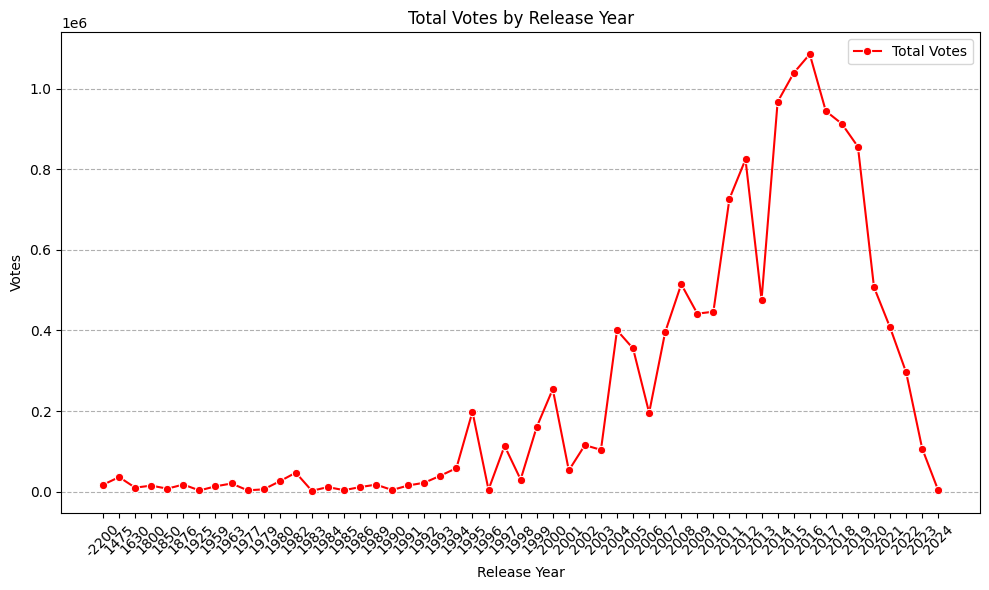

In [253]:
# Convert 'Total_Votes' column to numeric
df['Total_Votes'] = pd.to_numeric(df['Total_Votes'], errors='coerce')

# Group the data by 'Release_Date' and calculate the average 'Geek_rating' and total votes
average_geek_rating = df.groupby('Release_Date')['Geek_rating'].mean().reset_index()
total_votes = df.groupby('Release_Date')['Total_Votes'].sum().reset_index()

plt.figure(figsize=(10, 6))

sns.lineplot(data=total_votes, x='Release_Date', y='Total_Votes', marker='o', color='red', label='Total Votes')

plt.title('Total Votes by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Votes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

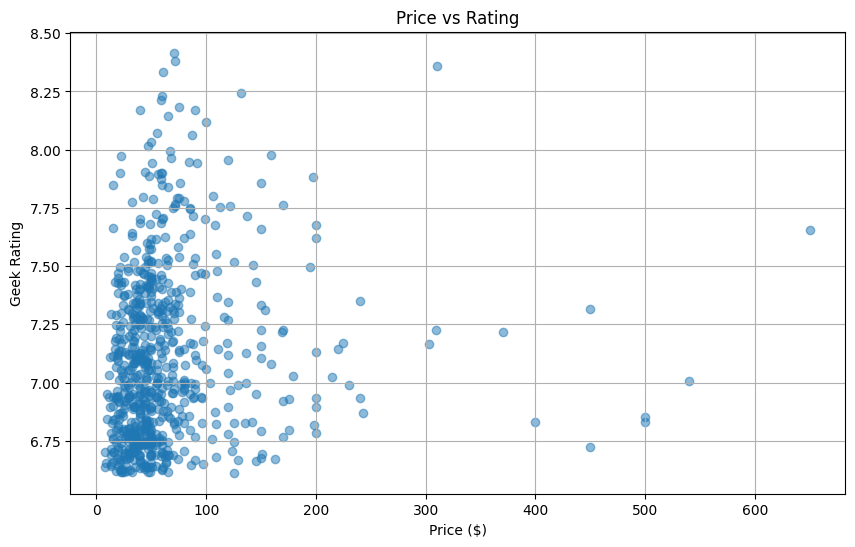

In [177]:
import pandas as pd
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.scatter(df['Amazon_Price($)'], df['Geek_rating'], alpha=0.5)
plt.title('Price vs Rating')
plt.xlabel('Price ($)')
plt.ylabel('Geek Rating')
plt.grid(True)
plt.show()

In [178]:
df.loc[df["Amazon_Price($)"]==649.99]  # most expensive game

,Title,Rank,Release_Date,Geek_rating,AVG_rating,Total_Votes,Amazon_Price($),Amazon_Link,Brief Description
72,Kingdom Death: Monster,73,2015,7.655,8.5,9596,649.99,https://www.amazon.com/dp/B01CMFKKDW?tag=brows...,Try to survive in a nightmarish world that lie...


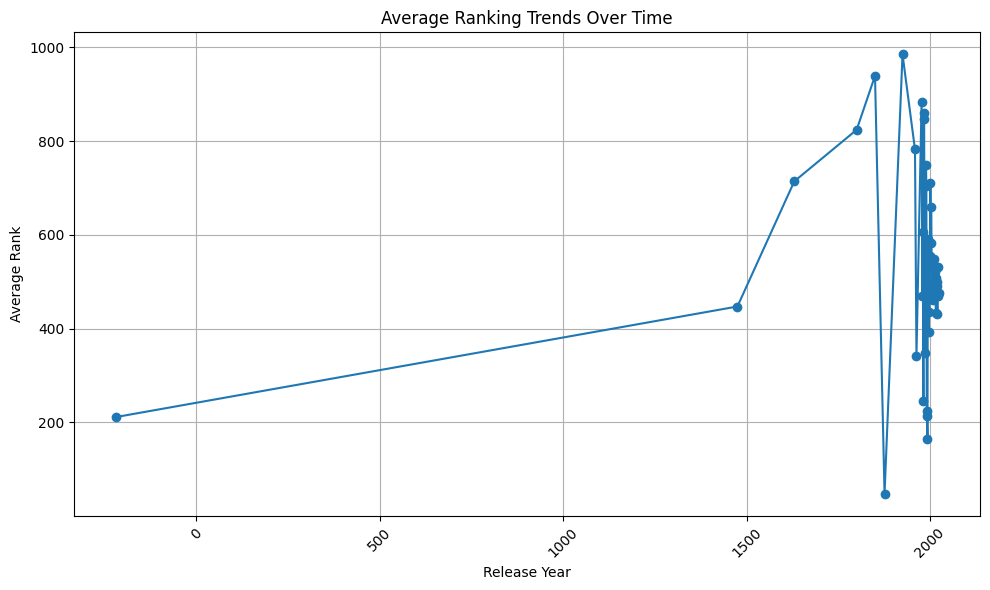

In [181]:
# With the -2200 year!

import pandas as pd
import matplotlib.pyplot as plt


# Extracting year from Release_Date and converting to numeric type
df['Release_Year'] = df['Release_Date'].astype(str).str[:4].astype(int)

# Group by year and calculate average rank
average_rank_per_year = df.groupby('Release_Year')['Rank'].mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(average_rank_per_year.index, average_rank_per_year.values, marker='o', linestyle='-')
plt.title('Average Ranking Trends Over Time')
plt.xlabel('Release Year')
plt.ylabel('Average Rank')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


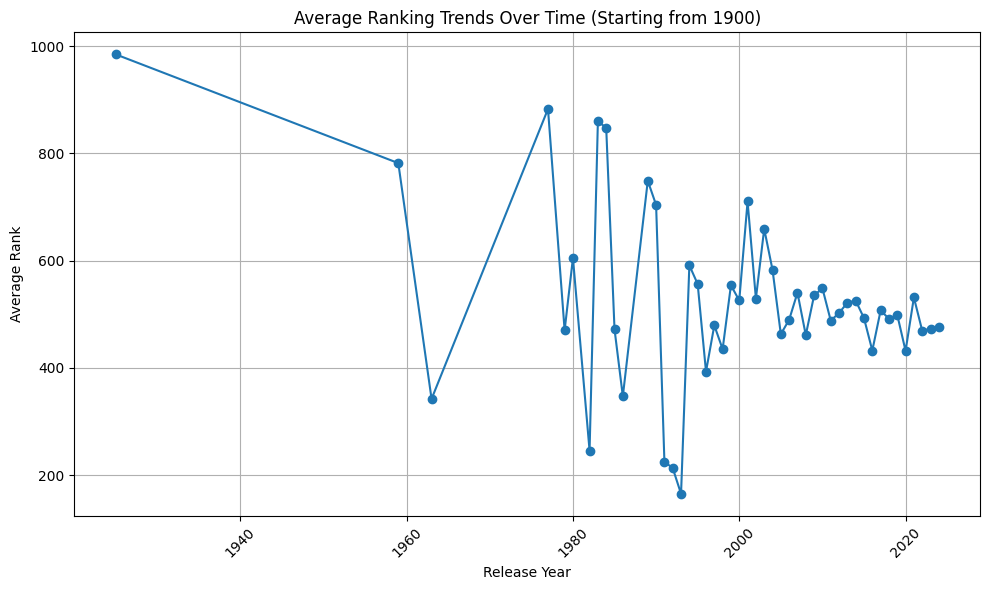

In [184]:
# starting from 1900
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is named df

# Extracting year from Release_Date and converting to numeric type
df['Release_Year'] = df['Release_Date'].astype(str).str[:4].astype(int)

# Filtering out rows with release years before 1900
df = df.loc[df['Release_Year'] >= 1900]

# Group by year and calculate average rank
average_rank_per_year = df.groupby('Release_Year')['Rank'].mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(average_rank_per_year.index, average_rank_per_year.values, marker='o', linestyle='-')
plt.title('Average Ranking Trends Over Time (Starting from 1900)')
plt.xlabel('Release Year')
plt.ylabel('Average Rank')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()



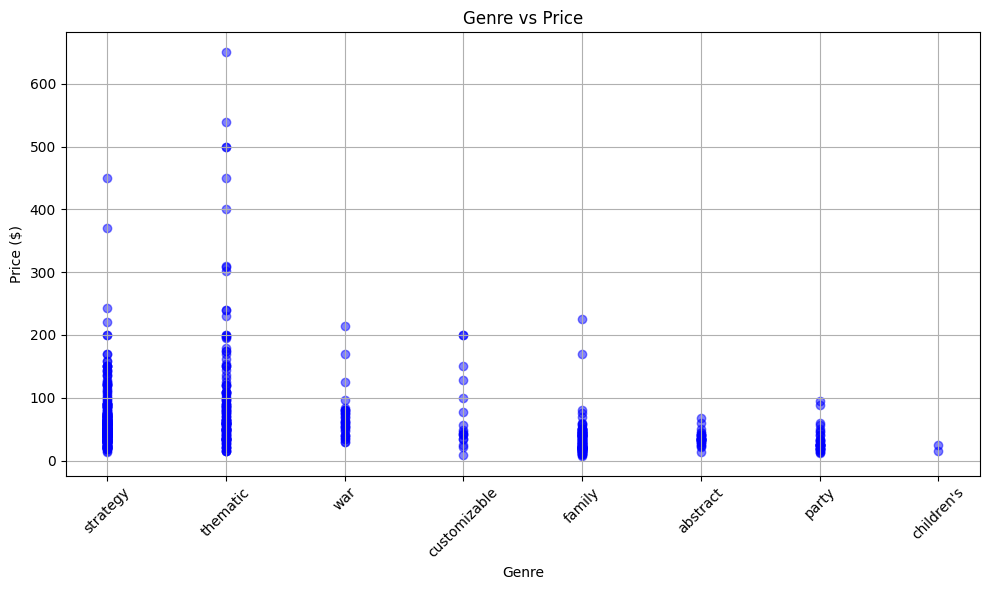

In [206]:
df = df.dropna(subset=['Amazon_Price($)'])

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df['Genre'], df['Amazon_Price($)'], color='b', alpha=0.5)
plt.title('Genre vs Price')
plt.xlabel('Genre')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()

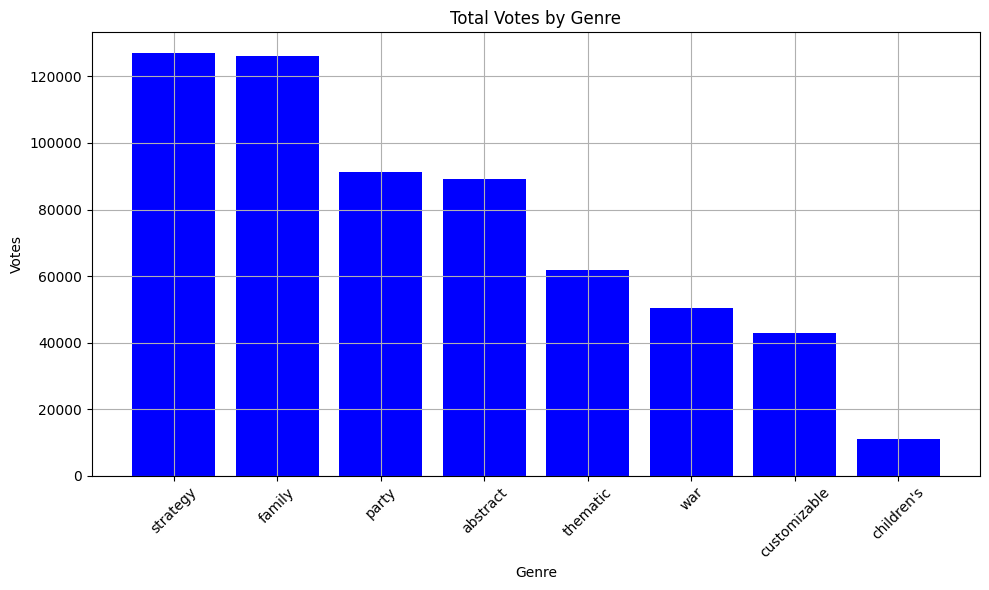

In [228]:
df = df.sort_values(by='Total_Votes', ascending=False)

# Convert 'Total_Votes' to numeric
df['Total_Votes'] = pd.to_numeric(df['Total_Votes'])


# Plotting
plt.figure(figsize=(10, 6))
plt.bar(df['Genre'], df['Total_Votes'], color='b')
plt.title('Total Votes by Genre')
plt.xlabel('Genre')
plt.ylabel('Votes')
plt.xticks(rotation=45) 
plt.grid(True)
plt.tight_layout()
plt.show()

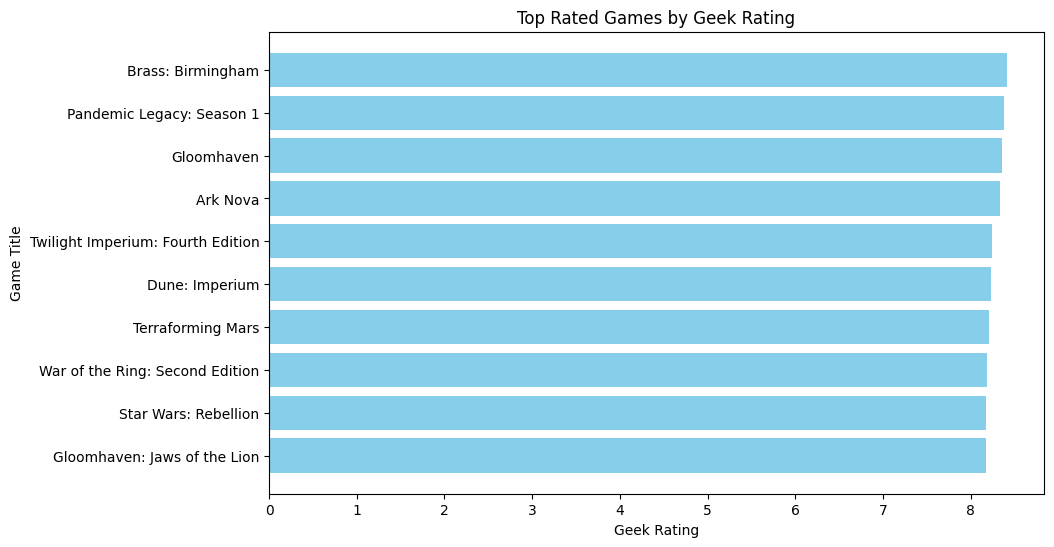

In [229]:
top_rated_games = df.nlargest(10, 'Geek_rating')

# Create a bar chart for top rated games
plt.figure(figsize=(10, 6))
plt.barh(top_rated_games['Title'], top_rated_games['Geek_rating'], color='skyblue')
plt.xlabel('Geek Rating')
plt.ylabel('Game Title')
plt.title('Top Rated Games by Geek Rating')
plt.gca().invert_yaxis()  # Invert y-axis to display highest rating at the top
plt.show()

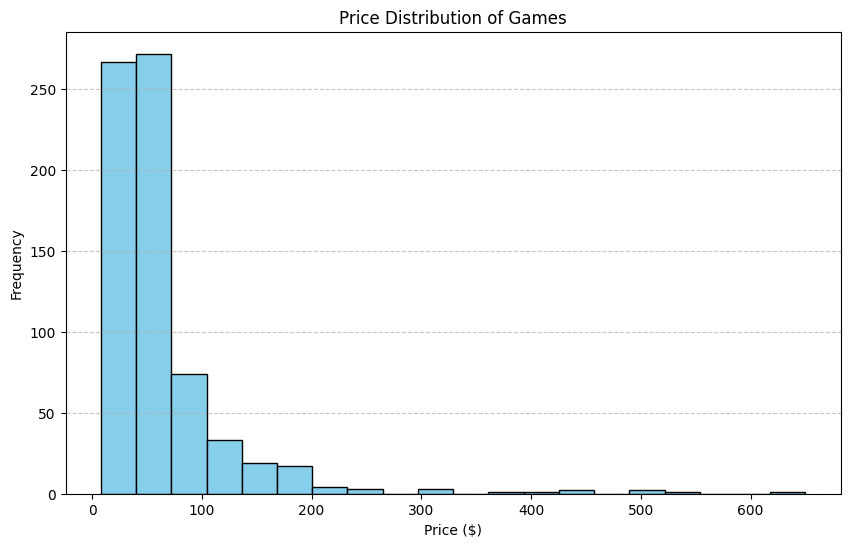

In [230]:
df_filtered = df.dropna(subset=['Amazon_Price($)'])

# Create a histogram for the price distribution
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['Amazon_Price($)'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.title('Price Distribution of Games')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

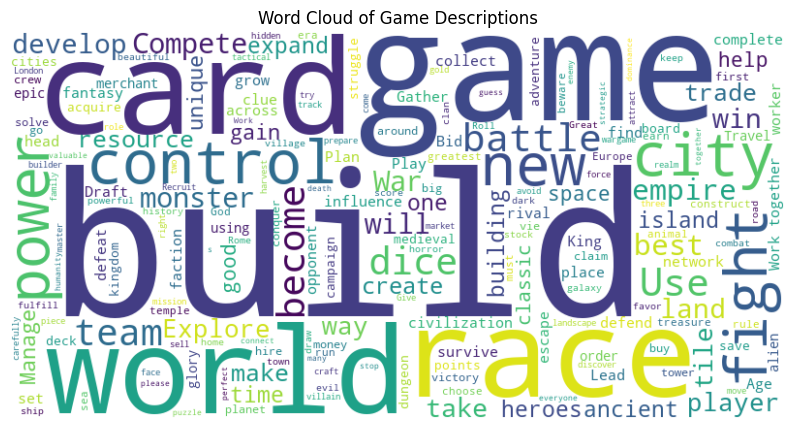

In [239]:
from wordcloud import WordCloud

df_cleaned = df.dropna(subset=['Brief Description'])

# Join all brief descriptions into a single string
text = ' '.join(df_cleaned['Brief Description'].astype(str))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Game Descriptions')
plt.axis('off')
plt.show()

In [245]:
df.sort_values(by="Rank")

,Title,Genre,Rank,Release_Date,Geek_rating,AVG_rating,Total_Votes,Amazon_Price($),Amazon_Link,Brief Description
0,Brass: Birmingham,strategy,1,2018,8.416,8.60,44976,70.45,https://www.amazon.com/dp/1988884047?tag=brows...,"Build networks, grow industries, and navigate ..."
1,Pandemic Legacy: Season 1,thematic,2,2015,8.382,8.53,53182,71.98,https://www.amazon.com/dp/B00TQ0DXR2?tag=brows...,Mutating diseases are spreading around the wor...
2,Gloomhaven,thematic,3,2017,8.357,8.59,61801,309.95,https://www.amazon.com/dp/B01LZXVN4P?tag=brows...,Vanquish monsters with strategic cardplay. Ful...
3,Ark Nova,strategy,4,2021,8.333,8.54,42289,60.81,https://www.amazon.com/dp/B09L6FCP9S?tag=brows...,"Plan and build a modern, scientifically manage..."
4,Twilight Imperium: Fourth Edition,thematic,5,2017,8.243,8.61,23453,131.99,https://www.amazon.com/dp/B074YPSTRP?tag=brows...,"Build an intergalactic empire through trade, r..."
...,...,...,...,...,...,...,...,...,...,...
995,Thunder Alley,thematic,996,2014,6.615,7.30,3576,48.85,https://www.amazon.com/dp/B00L3CTHLC?tag=brows...,Race your team of cars most efficiently to win...
996,Tidal Blades: Heroes of the Reef,strategy,997,2020,6.614,7.51,2899,NaN,NaN,"Join a tournament to become a Tidal Blade, gua..."
997,DinoGenics,thematic,998,2019,6.613,7.62,2395,NaN,NaN,Build and manage your own dinosaur island resort.
998,Virgin Queen,war,999,2012,6.613,8.01,1742,125.00,https://www.amazon.com/dp/B007PNT5B0?tag=brows...,Multiplayer European conflict during the Count...


In [246]:
df["Amazon_Price($)"].mean()

64.06137142857143